In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
from functions import cleaning_data, correlation_matrix, histogram, boxplot_outliers, testing_models, compare_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# Data exploration

In [3]:
df = pd.read_csv("data/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- The dataset contains information about patients related to the risk of suffering a stroke. In particular, it includes features such as age, whether the patient has hypertension, heart disease, marital status, work type, average glucose level, body mass index (BMI), among other variables.

- Additionally, it contains the target variable stroke, which indicates whether the patient has suffered a stroke (1) or not (0).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


- The columns contain different data types: integers (int64), floats (float64), and text strings (object).

- A first observation is that the column bmi (Body Mass Index) has some missing values (201 null values), which will need to be addressed later. All other columns are complete.

In [5]:
df.shape

(5110, 12)

- The dataset contains 5110 rows and 12 columns, which indicates a relatively large sample of patients to work with in our predictive analysis.

In [6]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [7]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

- The only column with missing values is bmi, with 201 null values. This represents approximately 4% of the data. These missing values can be handled depending on the data distribution. A decision will be made later.

In [8]:
df.duplicated().sum()

0

# Data cleaning

In [9]:
warnings.filterwarnings('ignore')

In [10]:
df = cleaning_data(df)

- We transformed several categorical columns into numerical variables and logically addressed the missing values.

- In the gender column, there was a category "Other" that only contained one record. Since most of the data corresponds to female patients, we decided to assign that value to the female category.

- The missing values in the Body Mass Index (BMI) column were filled with the column's mean. This is a common technique to impute missing values in continuous variables.

- Since the id column does not provide predictive value, it was removed from the analysis.

- Instead of applying One Hot Encoding for work_type, we followed a logic of assigning continuous numerical values to the work_type column, which allows us to relate job types to potential stress levels. This categorization will enable us to more intuitively assess the impact of job type on variables such as stress or stroke risk. The hierarchy we followed is:

    - Children -> 0
    - People who have never worked -> 1
    - Government employees -> 2
    - Private sector employees -> 3
    - Self-employed -> 4

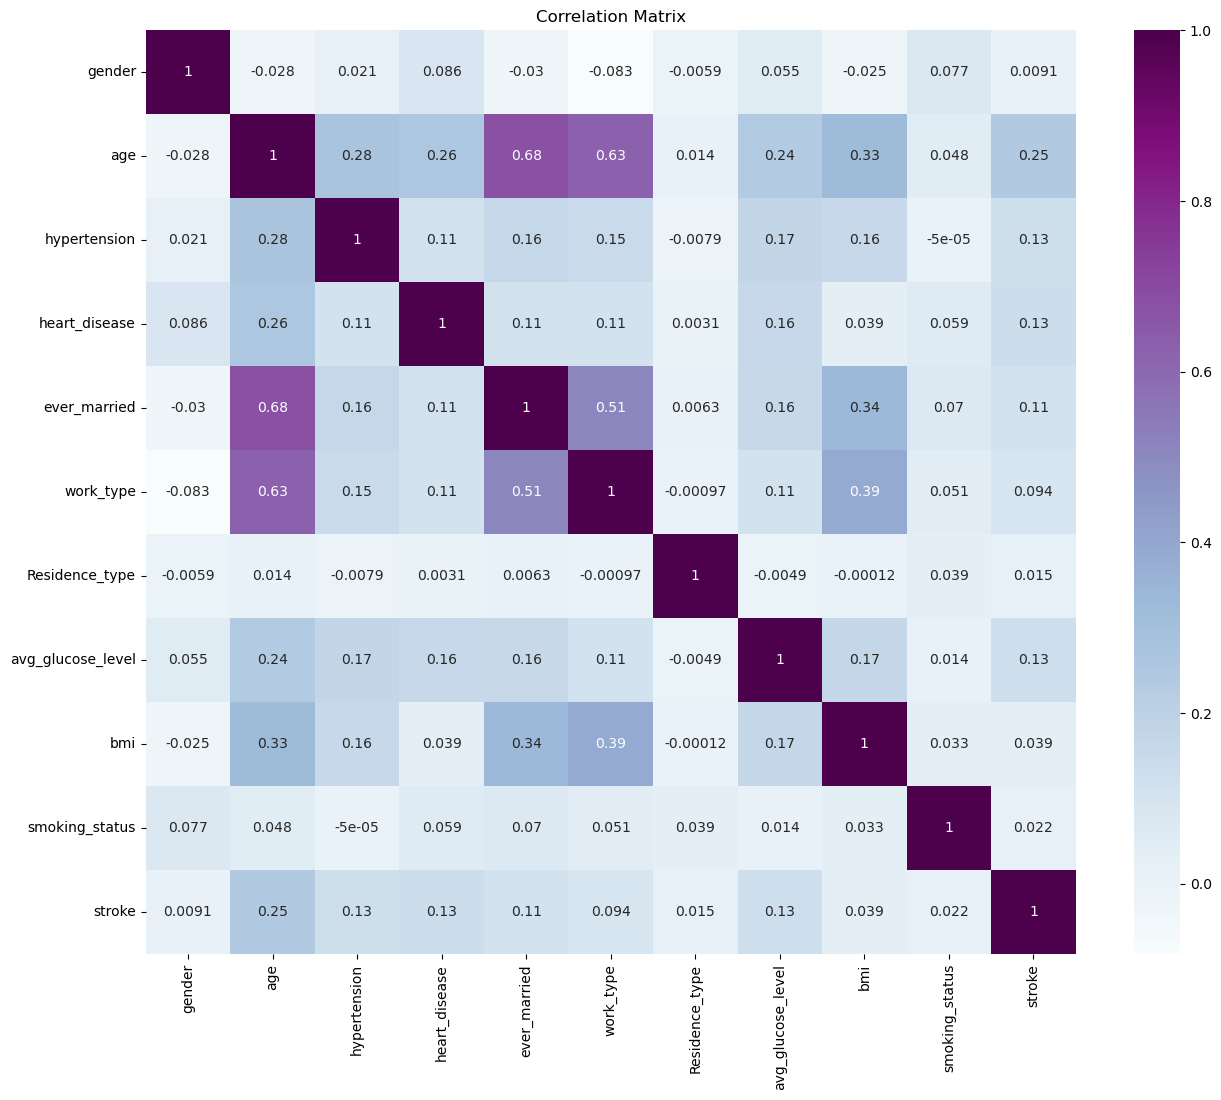

In [11]:
correlation_matrix(df, (15,12))

- This chart helps us identify correlations between variables, which influence the performance of predictive models. Variables that are not correlated with our target could be redundant, and highly correlated variables used for training should be filtered.

- The variable age shows the highest correlations with other important variables such as work_type, BMI, and stroke.

- Variables like hypertension, heart disease, and average glucose level have lower correlations with the target variable (stroke), but they are still relevant for predictive analysis since correlation is not the only factor to consider.

In [12]:
df = df.drop(columns = ['gender', 'Residence_type', 'smoking_status', 'ever_married'])

- These columns are removed because they do not show a relevant correlation with the target variable. In some cases, variables like gender and Residence_type may not provide significant differences in the model and could generate noise.

In [15]:
df.head()

,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,stroke
0,67.0,0,1,3,228.69,36.600000,1
1,61.0,0,0,4,202.21,28.893237,1
2,80.0,0,1,3,105.92,32.500000,1
3,49.0,0,0,3,171.23,34.400000,1
4,79.0,1,0,4,174.12,24.000000,1


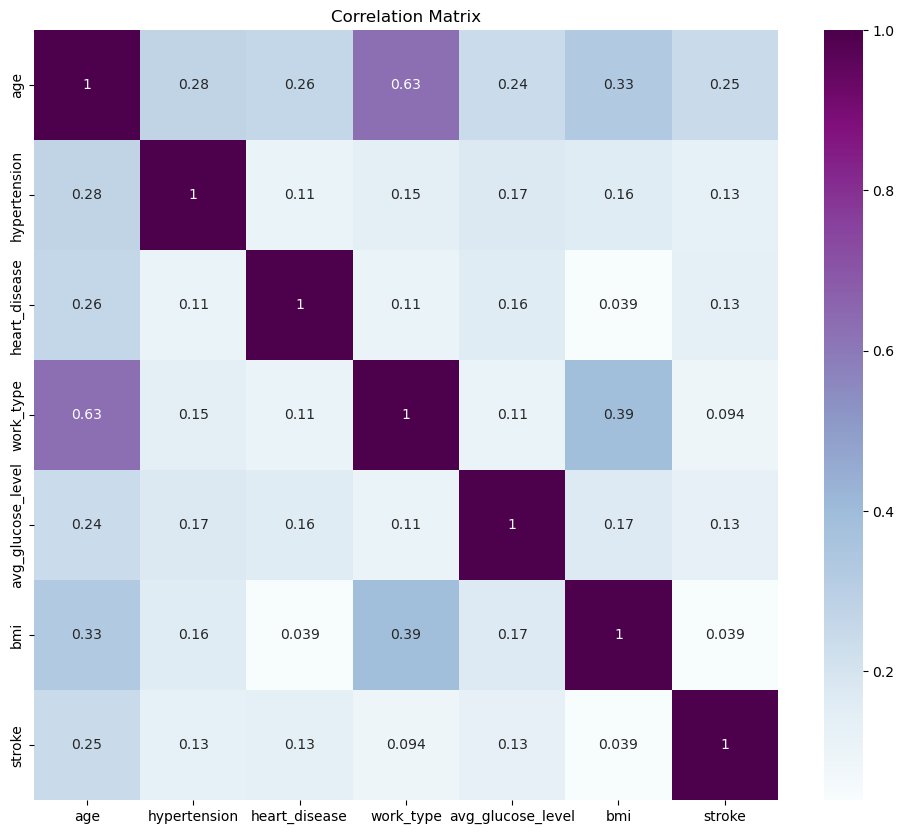

In [13]:
correlation_matrix(df, (12,10))

# Data visualization

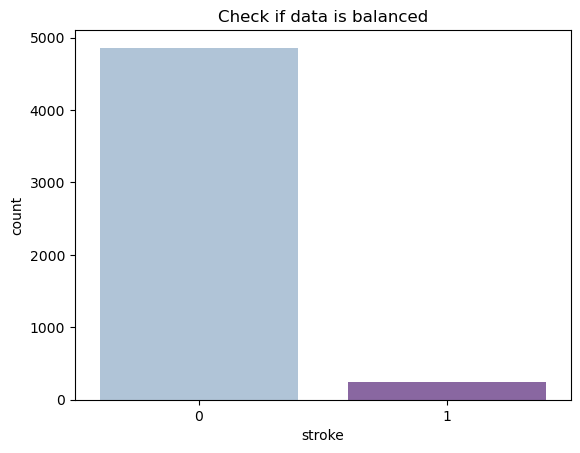

In [14]:
sns.countplot(data = df , x='stroke' ,  palette = 'BuPu')
plt.title("Check if data is balanced")
plt.show()

- The chart shows a significant imbalance in the target variable. There are many more instances of class 0 (did not have a stroke) compared to class 1 (had a stroke).

- This imbalance will be a key factor. Training predictive models with imbalanced data can lead to a bias towards the majority class, resulting in inadequate performance for predicting the minority class (stroke = 1).

- We will conduct a preliminary analysis of predictive models without modifying the class balance to get a first impression of the model's performance. Later, we will apply oversampling techniques, such as SMOTE, to balance the classes.

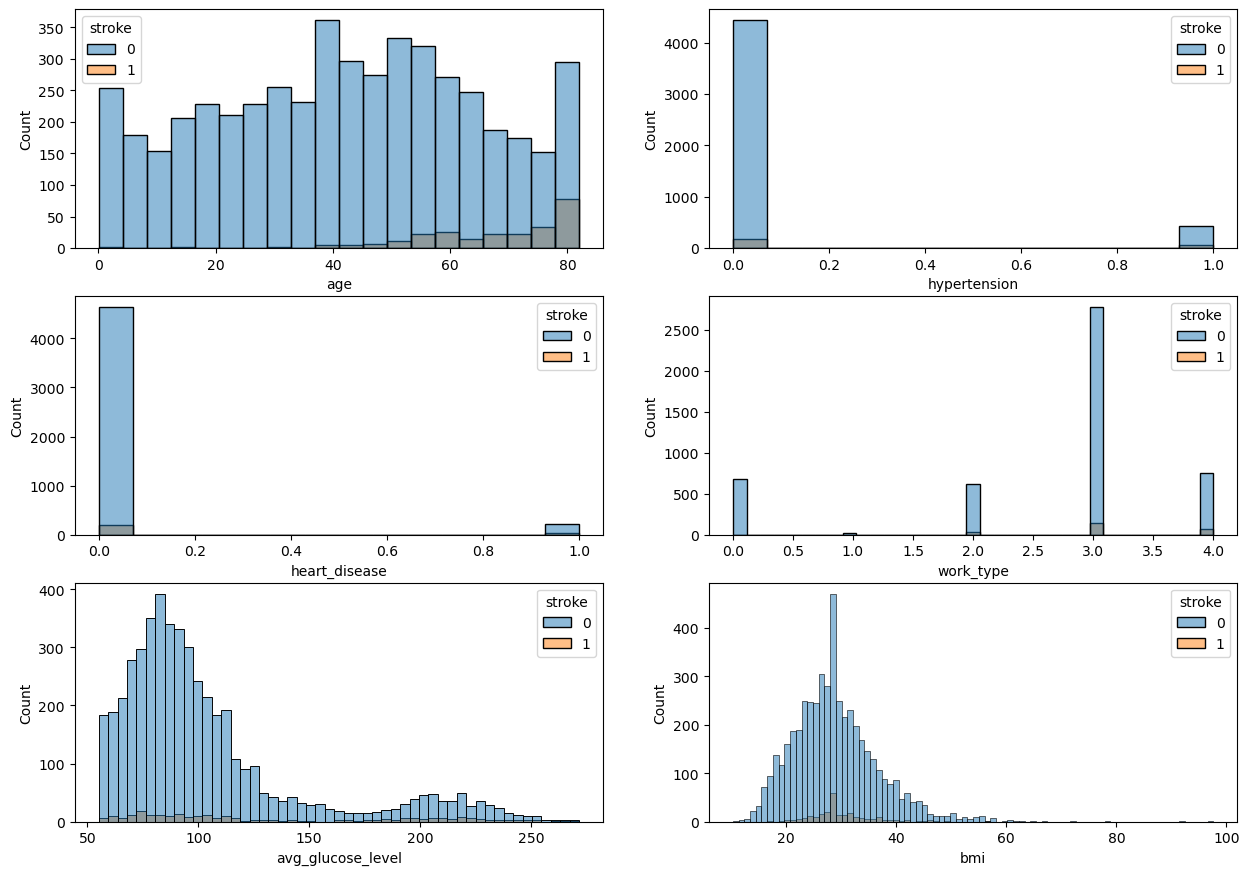

In [81]:
histogram(df)

- Age has a relatively wide distribution, but strokes seem to be more concentrated in patients over 60 years old, which is consistent with known stroke risk factors.

- Most patients do not have hypertension or heart disease. However, among patients who suffered a stroke, there is a higher proportion of those with these risk factors, which is expected since both conditions are known stroke risk factors.

- Most patients work in the private sector, with lower representation in other sectors. However, strokes seem to be more distributed in our classification of jobs related to stress, which appears to validate our label encoding distribution.

- Glucose levels have a right-skewed distribution, with some patients showing very high levels. Stroke patients seem to have higher average glucose levels.

- BMI distribution is relatively symmetric, with most patients in a normal range. However, patients who have suffered a stroke tend to cluster in the higher BMI range, indicating a possible correlation between obesity and stroke risk.

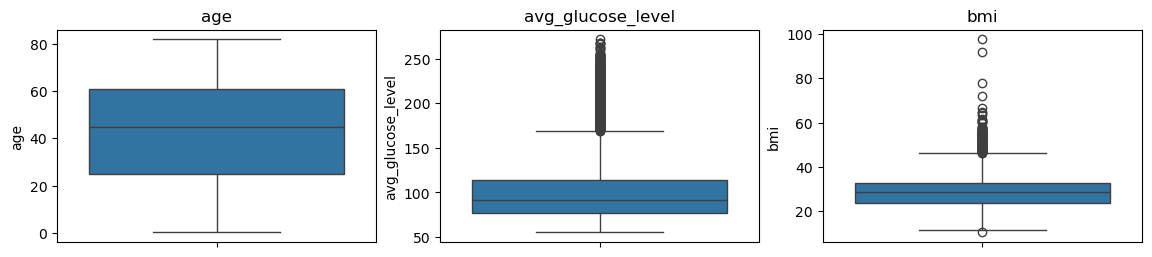

In [82]:
boxplot_outliers(df)

- The variable age has a reasonably uniform distribution, without significant outliers. The median is around 50 years.

- The average glucose level shows a considerable number of outliers above the expected range. This could indicate patients with health conditions related to metabolic disorders, such as diabetes.

- Although most BMI values are concentrated in a normal range (20-40), there is also a considerable number of outliers, suggesting the presence of patients with extreme obesity or underweight.

# Models

- We set up several machine learning algorithms to predict the target variable stroke. We have selected six common classification models, covering both linear and non-linear methods.

In [83]:
X = df.drop('stroke', axis=1) 
y = df['stroke']

- First, we separate the independent variables (X) from the target variable (y).

    - 'X' contains all the features from the dataset except the target variable. These are the features that the models will use to make their predictions.
    
    - 'y' is the target variable, which indicates whether a patient has suffered a stroke (1) or not (0).

In [130]:
models = {
  'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
  'Decision Tree': DecisionTreeClassifier(random_state=42),
  'Random Forest': RandomForestClassifier(random_state=42),
  'SVM': SVC(random_state=42),
  'KNN': KNeighborsClassifier(),
  'NB' : GaussianNB(),
}

- Logistic Regression is a linear model that is easy to interpret and is often effective in binary classification problems.

- Decision Tree is a non-linear model that creates a decision tree based on the features of the dataset.

- Random Forest is an ensemble model that combines several decision trees to improve accuracy and reduce overfitting.

- SVM (Support Vector Machine) is a linear and non-linear model that aims to maximize the margins between classes, useful when the classes are well separated.

- KNN (K-Nearest Neighbors) is an instance-based model that classifies points based on their closest neighbors.

- Naive Bayes (NB) is a probabilistic model that assumes independence between features. It is effective in problems with simple distributions and is computationally efficient.

## Before oversampling

- Before applying the oversampling technique, we will evaluate the performance of the models using the original data. This will give us a first impression of the models' behavior without addressing the class imbalance.

In [131]:
results_df, conf = testing_models(X, y, models)

- This function trains and evaluates several machine learning models. For each model, the function tests different preprocessing combinations:

    - With and without outliers (2 configurations).

    - Three types of scaling: No scaling, Standardization, Normalization (3 configurations).

        - Standard scaling is performed using StandardScaler, and normalization is done with MinMaxScaler.

    - In total, 6 tests are run for each model, providing a detailed view of how the models behave under different conditions.

- The data is split into training and test sets (80% training, 20% test) in each preprocessing scenario.

- The function returns a DataFrame (results_df) containing the key metrics (Accuracy, Precision, Recall, and F1score) for each model in the various configurations, and a dictionary (conf) with the corresponding confusion matrices to evaluate performance in each scenario.

In [132]:
results_df.sort_values(by='Precision' , ascending=False).style.background_gradient(cmap='BuPu')

,Model,Outliers,Scaling,Accuracy,Precision,Recall,F1score
26,Random Forest,Without Outliers,Standardization,0.959044,0.500000,0.027778,0.052632
32,Random Forest,Without Outliers,Normalization,0.959044,0.500000,0.027778,0.052632
28,KNN,Without Outliers,Standardization,0.959044,0.500000,0.027778,0.052632
20,Random Forest,Without Outliers,No Scaling,0.959044,0.500000,0.027778,0.052632
14,Random Forest,With Outliers,Normalization,0.938356,0.400000,0.032258,0.059701
2,Random Forest,With Outliers,No Scaling,0.938356,0.400000,0.032258,0.059701
8,Random Forest,With Outliers,Standardization,0.938356,0.400000,0.032258,0.059701
34,KNN,Without Outliers,Normalization,0.957907,0.333333,0.027778,0.051282
16,KNN,With Outliers,Normalization,0.937378,0.333333,0.032258,0.058824
17,NB,With Outliers,Normalization,0.870841,0.226562,0.467742,0.305263


- When observing the results, the F1-score is the most relevant metric, as it takes into account both precision and recall, and is especially useful in situations with class imbalance, such as in the stroke prediction dataset.

- The Naive Bayes models consistently rank in the top three positions in terms of F1-score, suggesting that they perform well for this specific problem, although their precision is low. Recall is Naive Bayes' strength, as it correctly identifies more stroke cases, albeit at the cost of generating some false positives.
    
    - Interestingly, Naive Bayes behaves similarly across different preprocessing configurations, making it a robust model in terms of scaling techniques or handling outliers.

- Decision tree models occupy the next category of performance, with an F1-score of approximately 0.23 when there are no outliers and standardization or no scaling techniques are used. However, precision and recall are quite low compared to Naive Bayes, meaning decision trees are not as effective at correctly identifying stroke cases.

- Despite achieving high accuracy (~0.95), Random Forest and KNN models have an extremely low F1-score (around 0.05). This is because these models have high precision only in the majority class (no stroke) but fail to correctly identify stroke cases, as reflected in their low recall and precision for the minority class.

- Both SVM and Logistic Regression models show poor results with F1-scores of 0, indicating that these models did not correctly identify any positive stroke cases. Despite their high accuracy, their lack of recall makes them inadequate for this imbalanced problem.

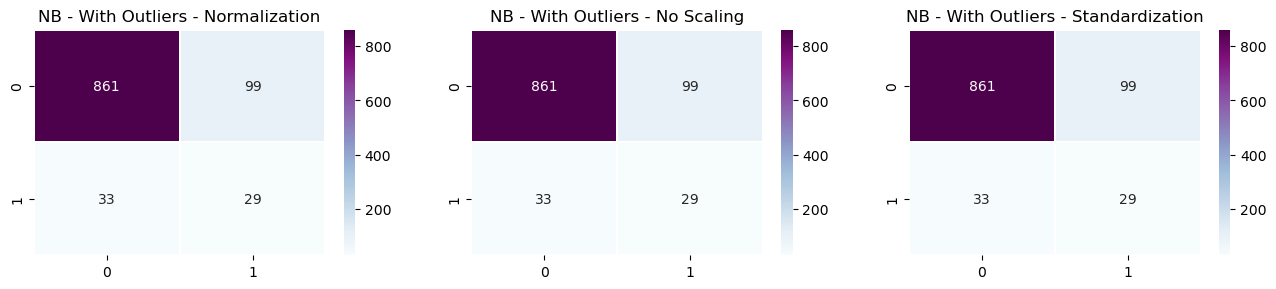

In [133]:
compare_confusion_matrix(results_df, conf)

- In all three configurations, the model correctly classifies the majority of patients who have not suffered a stroke. Out of the 960 total cases in class 0, the model correctly identifies 861 cases in each configuration.

- However, there is also a significant number of false positives in all cases: 99 patients who have not suffered a stroke were incorrectly classified as having had one.

- For patients who have suffered a stroke (class 1), the model is less effective. It only manages to correctly identify 29 cases in all three configurations.

- Additionally, there are 33 false negatives, meaning the model failed to detect those patients who actually suffered a stroke, incorrectly classifying them as not having had one.

- The model's performance is much better for the majority class (no stroke), while it struggles more to correctly identify stroke cases. This is expected given the class imbalance, where class 1 (stroke) is considerably smaller in the dataset.

    - This highlights the need to apply techniques such as oversampling to balance the classes and improve predictive performance for the minority class.

## Oversampling

In [119]:
sm=SMOTE(random_state=42)
X_os,y_os=sm.fit_resample(X,y)

- SMOTE is an oversampling technique that generates synthetic examples for the minority class (in this case, patients who have suffered a stroke) instead of simply duplicating existing samples.

    - This helps to balance the dataset and reduce the bias towards the majority class.

- X_os and y_os are the new balanced datasets. After applying SMOTE, both the majority class (no stroke) and the minority class (stroke) will have the same number of samples.

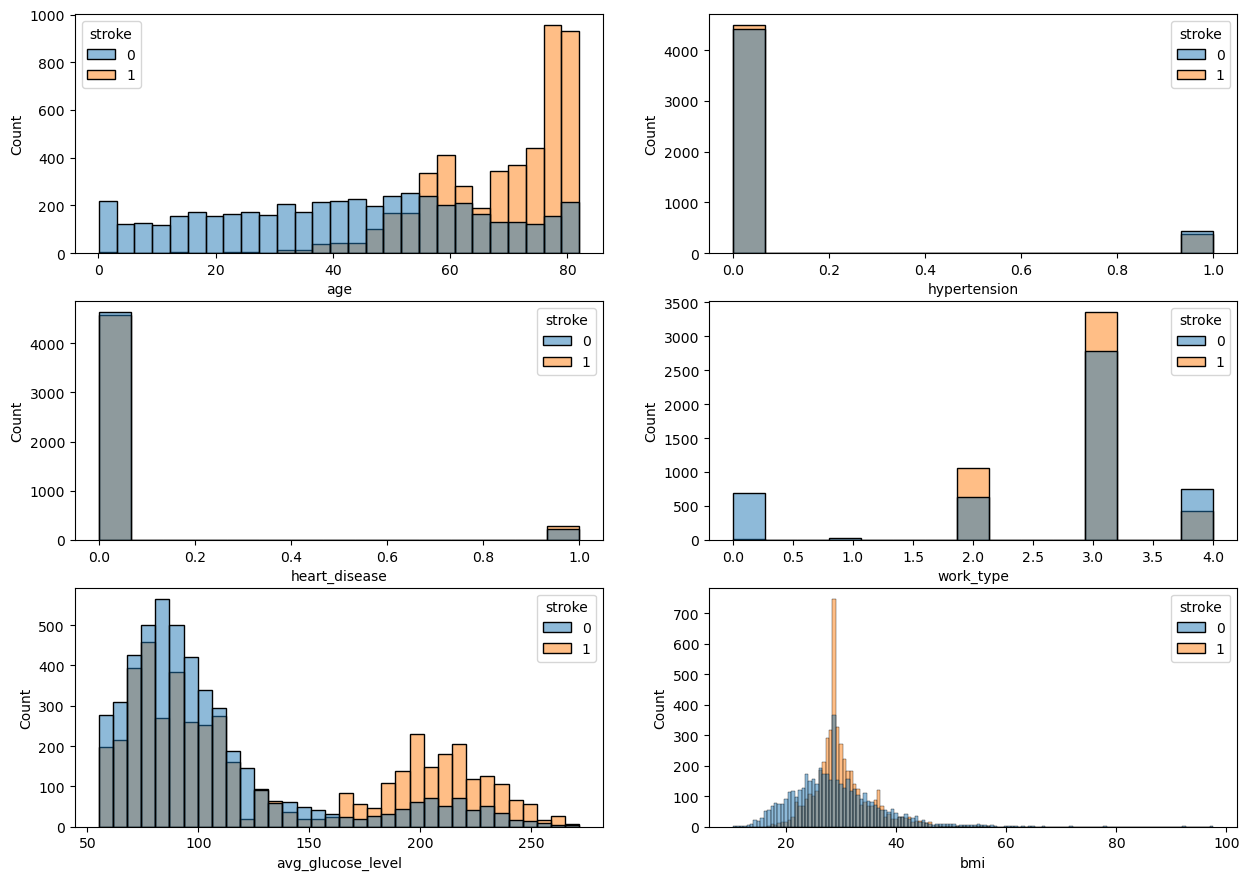

In [120]:
df_os = X_os.copy()
df_os['stroke'] = y_os
histogram(df_os)

In [121]:
y_os.value_counts()

stroke
1    4861
0    4861
Name: count, dtype: int64

In [122]:
results_os_df, conf_os = testing_models(X_os, y_os, models)

In [123]:
results_os_df.sort_values(by='Precision' , ascending=False).style.background_gradient(cmap='BuPu')

,Model,Outliers,Scaling,Accuracy,Precision,Recall,F1score
2,Random Forest,With Outliers,No Scaling,0.936761,0.920556,0.955670,0.937785
8,Random Forest,With Outliers,Standardization,0.936761,0.920556,0.955670,0.937785
14,Random Forest,With Outliers,Normalization,0.935219,0.919483,0.953608,0.936235
26,Random Forest,Without Outliers,Standardization,0.931522,0.917695,0.950959,0.934031
32,Random Forest,Without Outliers,Normalization,0.931522,0.917695,0.950959,0.934031
20,Random Forest,Without Outliers,No Scaling,0.931522,0.917695,0.950959,0.934031
25,Decision Tree,Without Outliers,Standardization,0.905435,0.908994,0.905117,0.907051
19,Decision Tree,Without Outliers,No Scaling,0.904891,0.908896,0.904051,0.906467
31,Decision Tree,Without Outliers,Normalization,0.904891,0.908896,0.904051,0.906467
7,Decision Tree,With Outliers,Standardization,0.912082,0.900702,0.925773,0.913066


- F1-score continues to be the most relevant metric when analyzing the results. It balances both precision and recall, making it particularly useful for handling class imbalance, such as the stroke prediction problem.

- Random Forest models now rank consistently at the top with F1-scores above 0.93, indicating a substantial improvement in performance. Both precision and recall are well-balanced, meaning that the model is correctly identifying both stroke and non-stroke cases with high accuracy. The fact that Random Forest performs well across all scaling methods, with and without outliers, shows its robustness and generalization ability.

    - Random Forest is a clear winner in terms of overall performance, showing the highest F1-scores, especially with no scaling and standardization.

- Decision Tree models also perform well, with F1-scores around 0.91, just slightly below Random Forest. The performance is consistent across different preprocessing techniques, but slightly better when outliers are present, indicating that decision trees can handle noise in the data quite well.

- K-Nearest Neighbors (KNN) models exhibit good recall (around 0.96), meaning they successfully identify most stroke cases, but they suffer from lower precision, as they tend to classify too many false positives. This is typical behavior for KNN in imbalanced datasets after oversampling.

    - The F1-scores of KNN models range from 0.88 to 0.90, meaning they are decent performers but not as robust as Random Forest or Decision Tree models.

- SVM and Logistic Regression have improved F1-scores compared to the previous analysis without SMOTE. Both models now show F1-scores around 0.82, with better performance when outliers are removed and data is standardized. However, these models are still not as competitive as Random Forest and Decision Tree.

    - SVM still struggles more than other models, but it performs better than in the pre-SMOTE phase, highlighting the value of balancing the dataset.

- Naive Bayes models, which performed well before oversampling, have now dropped in rankings, with F1-scores around 0.78. Although they still show relatively high recall (correctly identifying stroke cases), their precision is lower, leading to more false positives. This suggests that Naive Bayes might not be as effective in handling oversampled data, possibly due to the assumptions it makes about feature independence.

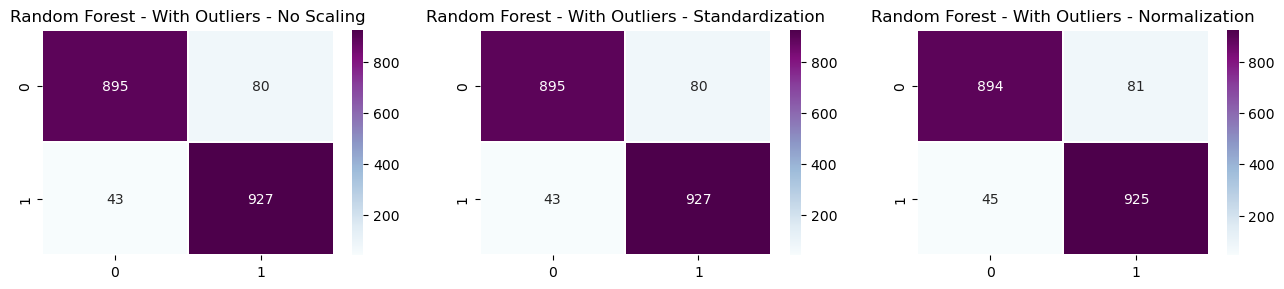

In [124]:
compare_confusion_matrix(results_os_df, conf_os)

- In all three configurations (with outliers and using different scaling techniques: Standardization, No Scaling, and Normalization), the model performs significantly better compared to the pre-SMOTE analysis.

- Out of the 975 total cases in class 0, the model correctly classifies 895 cases across all configurations. This is a slight improvement over the pre-SMOTE analysis where the model was correctly classifying 861 cases.

    - The number of false positives (patients who have not suffered a stroke but were classified as having one) has decreased to 80-81, compared to 99 in the previous analysis. This shows that the model has improved its precision for class 0.

- In class 1 (Stroke), the model now identifies a much higher number of stroke cases correctly, with 925-927 correct predictions out of 970 total cases. This is a substantial improvement compared to the pre-SMOTE analysis, where the model was only identifying 29 stroke cases correctly.

    - The number of false negatives (patients who suffered a stroke but were classified as not having one) has reduced to 43-45, compared to 33 false negatives previously. While there are still some false negatives, the overall recall for class 1 has improved drastically.

- The overall balance between precision and recall has improved after applying SMOTE, particularly for the minority class (stroke cases). The model is now much better at identifying stroke cases without sacrificing too much precision for class 0.

# Under y Over Sampling

In [162]:
smote_enn = SMOTEENN(random_state=42, sampling_strategy=0.9)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

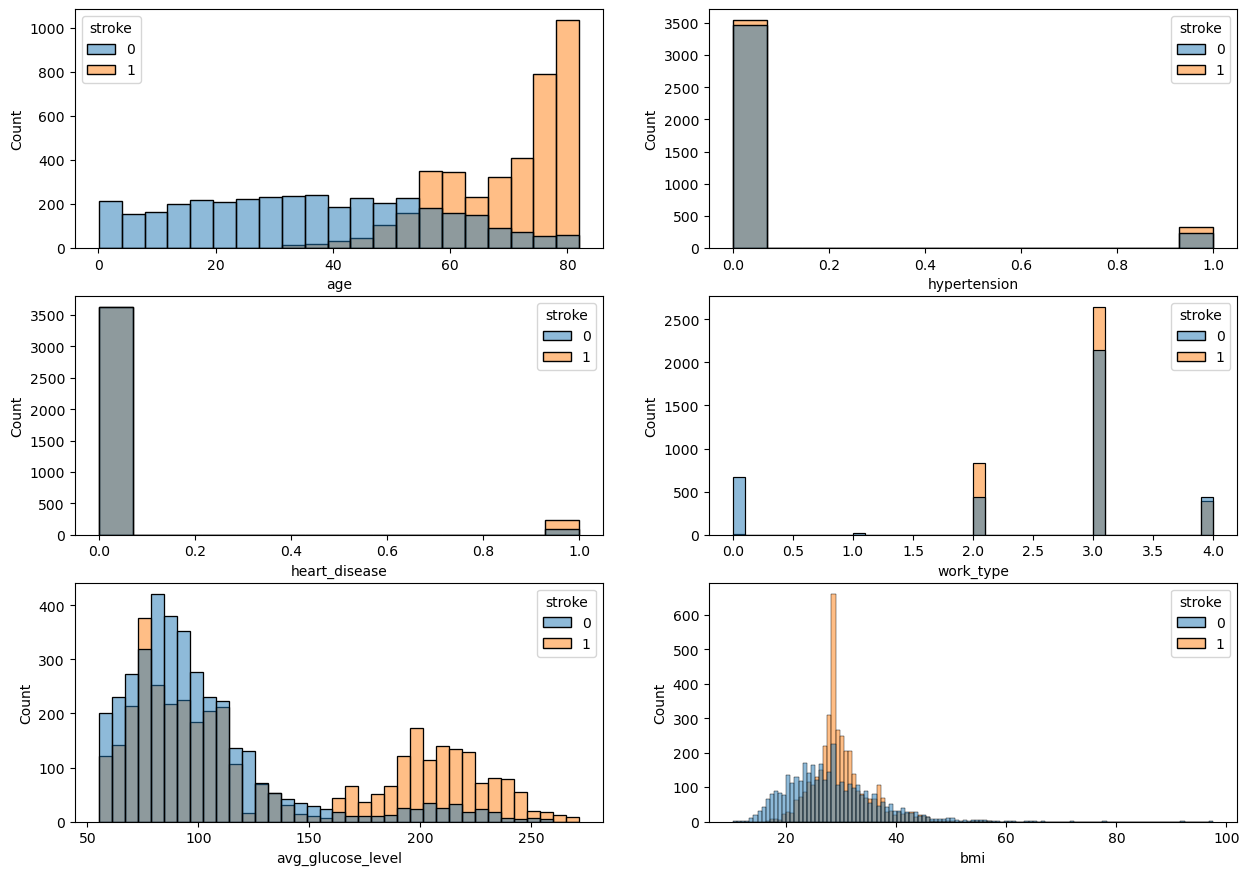

In [163]:
df_resampled = X_resampled.copy()
df_resampled['stroke'] = y_resampled
histogram(df_resampled)

In [164]:
y_resampled.value_counts()

stroke
1    3864
0    3709
Name: count, dtype: int64

In [165]:
results_resampled_df, conf_resampled = testing_models(X_resampled, y_resampled, models)

In [166]:
results_resampled_df.sort_values(by='Precision' , ascending=False).style.background_gradient(cmap='BuPu')

,Model,Outliers,Scaling,Accuracy,Precision,Recall,F1score
19,Decision Tree,Without Outliers,No Scaling,0.955170,0.948301,0.959641,0.953938
31,Decision Tree,Without Outliers,Normalization,0.955170,0.948301,0.959641,0.953938
25,Decision Tree,Without Outliers,Standardization,0.955170,0.948301,0.959641,0.953938
8,Random Forest,With Outliers,Standardization,0.961056,0.947771,0.976378,0.961862
14,Random Forest,With Outliers,Normalization,0.961056,0.947771,0.976378,0.961862
32,Random Forest,Without Outliers,Normalization,0.960954,0.947598,0.973094,0.960177
26,Random Forest,Without Outliers,Standardization,0.960954,0.947598,0.973094,0.960177
4,KNN,With Outliers,No Scaling,0.968317,0.947368,0.992126,0.969231
2,Random Forest,With Outliers,No Scaling,0.960396,0.946565,0.976378,0.961240
20,Random Forest,Without Outliers,No Scaling,0.960231,0.946221,0.973094,0.959469


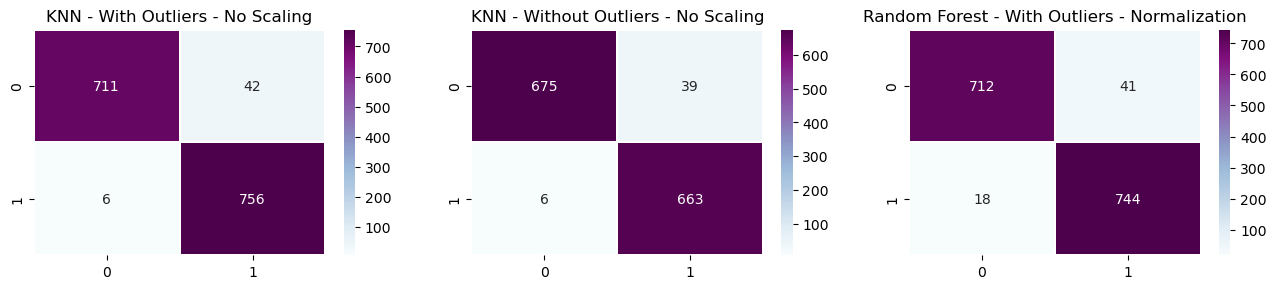

In [167]:
compare_confusion_matrix(results_resampled_df, conf_resampled)